Please fill in your name and netid (double-click the cell to edit).

Name: Phillip Huang

netid: ph390

---
# Neural Machine Translation with Vanilla RNNs, LSTMs, and Attention

In this assignment, you will implement Neural Machine Translation (NMT) models using:
1. Vanilla RNNs
2. LSTMs
3. LSTMs with attention

As in previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 462.                                   #
###############################################################################
# Replace "pass" statement with your code
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 462.                                   #
###############################################################################
# Replace "pass" statement with your code
x = 462
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks unless otherwise stated.
- Do not delete any cells from the notebook. You may add new cells to perform scratch work, but please delete them before submitting.
- Run all cells before submitting, so that your results are stored in the notebook.
- Submit your notebook as `netid.ipynb`, where `netid` is your actual netid.

In [ ]:
from __future__ import print_function
from __future__ import division

import math
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, invert_permutation
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
assert torch.cuda.is_available(), 'GPU unavailable'

## Data Preparation

We will use the dataset from this PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), and train neural networks to perform French-to-English translation. A preprocessed version is provided in `data.pickle`. Please put the file in the same directory as this notebook. In Google Colab, you have the option to upload files.

The preprocessed dataset contains 10K French and English sentence pairs. Each sentence consists of 9-16 tokens. We will use 8K sentence pairs for training, and the remaining 2K for validation.

In [ ]:
# Load data
with open('data.pickle', 'rb') as f:
  target_text, source_text = pickle.load(f)
print(f'There are {len(source_text)} fra-eng sentence pairs.')

# Show a random sample
idx = random.randrange(len(source_text))
print('Here is a random sample:')
print('source sentence (fra):', source_text[idx])
print('target sentence (eng):', target_text[idx])

# Split sentences into words
source_text = [sentence.split(' ') for sentence in source_text]
target_text = [sentence.split(' ') for sentence in target_text]
MAX_LEN = max(max([len(sentence) for sentence in source_text]),
              max([len(sentence) for sentence in target_text]))
print(f'The maximum sentence length is {MAX_LEN}.')

There are 10000 fra-eng sentence pairs.
Here is a random sample:
source sentence (fra): je veux toutes vous remercier pour du bon boulot .
target sentence (eng): i want to thank you all for a job well done .
The maximum sentence length is 16.


## Vocabulary

NMT models usually learn an embedding for each token. For this, PyTorch provides [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding) that stores these embeddings as a lookup table. When given the index of a token, this module can retrieve the token's embedding.

To make use of `nn.Embedding`, we need to map each token to an index. To convert model outputs back to readable tokens, we also need a reverse mapping that can retrieve the token given its index. The `Vocab` class below maintains exactly these two mappings. Note that to limit the vocabulary size and improve generalization, we do not store rare words in the vocabulary. They are replaced with the `'unk'` token.

In [ ]:
class Vocab:

  def __init__(self, text, min_freq=5):

    # Initialize the vocabulary with special tokens
    self.index2word = {
      0: 'pad',  # padding
      1: 'bos',  # begin of sentence
      2: 'eos',  # end of sentence
      3: 'unk',  # unknown
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.size = 4  # initial vocabulary size

    # Only add tokens that appear more than `min_freq` times in the training data
    tokens = [token for sentence in text for token in sentence]
    token_freq = Counter(tokens)
    tokens = [token for token in token_freq if token_freq[token] >= min_freq]
    self._build_vocab(tokens)


  def _build_vocab(self, tokens):

    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.size
        self.index2word[self.size] = token
        self.size += 1


  def __getitem__(self, tokens):

    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

In [ ]:
def get_data_loader(source_text, target_text, batch_size):
  """
  Build vocabulary and prepare data.
  """
  # Use the first 8000 pairs as training data, and the rest for validation
  source_vocab = Vocab(source_text[:8000])
  target_vocab = Vocab(target_text[:8000])

  # Convert each word to its index in the vocabulary
  source_text = source_vocab[source_text]
  # Record the length of each sentence
  source_len = [len(sentence) for sentence in source_text]
  # Pad each sentence to `MAX_LEN`
  source_text = [sentence + [source_vocab['pad']] * (MAX_LEN - len(sentence))
                 for sentence in source_text]
  # Convert to PyTorch tensors
  source_text = torch.LongTensor(source_text)  # shape: (num_sentences, MAX_LEN)
  source_len = torch.LongTensor(source_len)  # shape: (num_sentences,)

  # Convert each word to its index in the vocabulary
  target_text = target_vocab[target_text]
  # Add 'bos' and 'eos' tokens
  target_text = [[target_vocab['bos']] + sentence + [target_vocab['eos']]
                 for sentence in target_text]
  # Record the length of each sentence
  target_len = [len(sentence) for sentence in target_text]
  # Pad each sentence to `MAX_LEN` (+2 for 'bos' and 'eos')
  target_text = [sentence + [target_vocab['pad']] * (MAX_LEN + 2 - len(sentence))
                 for sentence in target_text]
  # Convert to PyTorch tensors
  target_text = torch.LongTensor(target_text)  # shape: (num_sentences, MAX_LEN+2)
  target_len = torch.LongTensor(target_len)  # shape: (num_sentences,)

  train_set = TensorDataset(
    source_text[:8000], source_len[:8000],
    target_text[:8000], target_len[:8000])

  val_set = TensorDataset(
    source_text[8000:], source_len[8000:],
    target_text[8000:], target_len[8000:])

  loader_kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }

  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)

  return source_vocab, target_vocab, train_loader, val_loader

In [ ]:
source_vocab, target_vocab, train_loader, val_loader = get_data_loader(
  source_text, target_text, batch_size=40)
print('source_vocab size:', source_vocab.size)
print('target_vocab size:', target_vocab.size)

source_vocab size: 1462
target_vocab size: 1237


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Sequence to Sequence Models for Neural Machine Translation

A popular approach to neural machine translation is to use sequence to sequence (seq2seq) models, as shown below.

<img src="https://raw.githubusercontent.com/dsgiitr/d2l-pytorch/master/img/seq2seq_predict.svg" width=600>

We first use the encoder to obtain an encoding of the source sentence. This encoding is then passed to the decoder which generates the translation one word at a time. Note that to start translation, we feed in the `'bos'` token. The generated word is then used as input for the next step. The translation is considered finished when the decoder outputs the `'eos'` token (i.e., all subsequent outputs are ignored).

During training, we use teacher forcing, which means we feed in the ground truth words to the decoder instead of the generated words, as shown below.

<img src="https://raw.githubusercontent.com/dsgiitr/d2l-pytorch/master/img/seq2seq.svg" width=600>

## Sequence to Sequence with Vanilla RNNs (15 points)

Let us first implement the simplest seq2seq model, which uses vanilla RNNs for both the encoder and the decoder.

- **Encoder**

    The encoder RNN has its hidden state initialized to zero. At each step, the encoder takes in a word in the source sentence, and updates the hidden state. The hidden state at the last step is thus an encoding of all the words in the source sentence.

- **Decoder**

    The encoder hidden state at the last step is used to directly initialize the decoder hidden state, which is then updated using the decoder RNN. The encoder and decoder RNNs do not share parameters. A fully connected layer is used to predict the next word from the decoder hidden state at each step. Its output is an unnormalized probability distribution over the target vocabulary.

<img src="https://raw.githubusercontent.com/dsgiitr/d2l-pytorch/master/img/seq2seq-details.svg" width=450>

Implement `EncoderRNN` and `DecoderRNN` below:

In [ ]:
class EncoderRNN(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  # word embeddings
    self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)


  def forward(self, source_text, source_len):
    # type: (Tensor, Tensor) -> Tensor
    """
    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).

    Returns:
    - source_hT: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the RNN hidden state at the end of each source sentence
      (i.e., `source_hT` encodes all tokens before the padding tokens).
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    embedded = self.embedding(source_text)
    packed_embedded = pack_padded_sequence(embedded, source_len.cpu(), batch_first=True, enforce_sorted=False)
    _, hidden_state = self.rnn(packed_embedded)
    source_hT = hidden_state.squeeze(0)
    # END OF YOUR CODE
    return source_hT

In [ ]:
class DecoderRNN(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  # word embeddings
    self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, vocab_size)


  def forward(self, target_text, source_hT):
    # type: (Tensor, Tensor) -> Tensor
    """
    For each word in each target sentence, predict its next word.

    Inputs:
    - target_text: A LongTensor of shape (batch_size, target_seq_len)
      containing a mini-batch of target sentences padded to `target_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_hT: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the RNN hidden state at the end of each source sentence
      (i.e., `source_hT` encodes all tokens before the padding tokens).

    Returns:
    - pred: A PyTorch tensor of shape (batch_size, target_seq_len, vocab_size)
      containing the next word predictions in the form of unnormalized scores
      for each possible word in the vocabulary.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    embedded = self.embedding(target_text)
    output, _ = self.rnn(embedded, source_hT.unsqueeze(0))
    pred = self.out(output)
    # END OF YOUR CODE
    return pred


  def predict(self, input_token, h_prev):
    # type: (Tensor, Tensor) -> Tuple[Tensor, Tensor]
    """
    Single-step prediction: For each input word, predict its next word.

    Inputs:
    - input_token: A LongTensor of shape (batch_size, 1)
      containing a mini-batch of input tokens.
      Each token is represented by its index in the vocabulary.
    - h_prev: A PyTorch tensor of shape (1, batch_size, hidden_size)
      containing the RNN encoding of all previous input tokens.

    Returns:
    - pred_token: A LongTensor of shape (batch_size, 1)
      containing the next word predictions.
      Each token is represented by its index in the vocabulary.
    - h: A PyTorch tensor of shape (1, batch_size, hidden_size)
      containing the updated RNN encoding that consumes the current input tokens.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the prediction phase.                                       #
    #########################################################################
    # Replace "pass" statement with your code
    embedded = self.embedding(input_token)
    output, h = self.rnn(embedded, h_prev)
    pred_token = self.out(output[:, -1])
    pred_token = torch.argmax(pred_token, dim=1, keepdim=True)
    # END OF YOUR CODE
    return pred_token, h

We now combine `EncoderRNN` and `DecoderRNN` to make a seq2seq model. You should not modify the code here.

In [ ]:
class NMT_RNN(nn.Module):

  def __init__(self, source_vocab_size, target_vocab_size, embedding_dim, hidden_size, max_pred_len):
    super().__init__()

    self.enc = EncoderRNN(source_vocab_size, embedding_dim, hidden_size)
    self.dec = DecoderRNN(target_vocab_size, embedding_dim, hidden_size)
    self.max_pred_len = max_pred_len


  def forward(self, source_text, source_len, target_text, target_len):
    # type: (Tensor, Tensor, Tensor, Tensor) -> Tensor
    """
    Perform next word prediction and compute loss.

    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).
    - target_text: A LongTensor of shape (batch_size, target_seq_len)
      containing a mini-batch of target sentences padded to `target_seq_len`.
      Each token is represented by its index in the vocabulary.
    - target_len: A LongTensor of shape (batch_size,)
      containing the actual length of each target sentence (before being padded).

    Returns:
    - loss: A PyTorch scalar containing the loss for the mini-batch.
    """
    source_hT = self.enc(source_text, source_len)
    pred = self.dec(target_text, source_hT)

    # Note that `target_text` contains many 'pad' tokens.
    # They should be excluded when we compute the loss.
    # To remove these 'pad' tokens, we can use `pack_padded_sequence()`.
    # Before doing that, we need to first sort target sentences in descending length.
    target_len, sorted_indices = torch.sort(target_len, descending=True)
    target_text = target_text.index_select(0, sorted_indices)
    pred = pred.index_select(0, sorted_indices)
    target_len = target_len.cpu()

    # Use `pack_padded_sequence()` to remove 'pad' tokens
    target_text_packed = pack_padded_sequence(
      target_text[:, 1:], target_len - 1,  # notice the shift in `target_text`
      batch_first=True, enforce_sorted=True)

    pred_packed = pack_padded_sequence(
      pred, target_len - 1,
      batch_first=True, enforce_sorted=True)

    loss = F.cross_entropy(pred_packed.data, target_text_packed.data, ignore_index=0)
    return loss


  def predict(self, source_text, source_len):
    # type: (Tensor, Tensor) -> Tensor
    """
    Predict the target sentence for each source sentence.
    The predicted word at step t will be used as input for step t+1.
    This is different from what is done in the forward pass.

    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).

    Returns:
    - pred: A LongTensor of shape (batch_size, max_pred_len)
      containing the predicted target sentences.
      Each token is represented by its index in the vocabulary.
    """
    h = self.enc(source_text, source_len).unsqueeze(0)
    input_token = torch.ones_like(source_len).view(-1, 1)  # feed in 'bos' to start
    pred_list = []

    for t in range(self.max_pred_len):  # predict up to `max_pred_len` steps
      pred_token, h = self.dec.predict(input_token, h)
      pred_list.append(pred_token)
      input_token = pred_token  # use the predicted token as input for next step

    pred = torch.cat(pred_list, dim=1)
    return pred

### Evaluation

To evaluate a trained NMT model, we use it to perform translation on some source sentences. The translation is generated by picking the most probable word predicted by the decoder at each step. We then compare the model translation with the ground truth translation, and compute the accuracy of the predicted words.

Please know that we choose the evaluation protocol here for simplicity. There are better decoding techniques (e.g., beam search) and evaluation metrics (e.g., BLEU scores) that you should use in your own projects.

In [ ]:
def eval_acc(model, data_loader, num_samples=5):

  with torch.no_grad():
    model.eval()

    total = 0
    correct = 0

    for batch, data in enumerate(data_loader):
      data = [d.cuda() for d in data]

      pred = model.predict(data[0], data[1])

      if batch < num_samples:  # show some samples
        source_sentence = [source_vocab.index2word[token] for token in data[0][0].tolist()]
        target_sentence = [target_vocab.index2word[token] for token in data[2][0].tolist()]
        pred_sentence = [target_vocab.index2word[token] for token in pred[0].tolist()]

        print(f'=== Sample {batch + 1} ===')
        print('source_sentence:', source_sentence)
        print('target_sentence:', target_sentence)
        print('pred_sentence:  ', pred_sentence)

      target_len, sorted_indices = torch.sort(data[3], descending=True)
      target_text = data[2].index_select(0, sorted_indices)
      pred = pred.index_select(0, sorted_indices)
      target_len = target_len.cpu()

      target_text_packed = pack_padded_sequence(
        target_text[:, 1:], target_len - 1,  # notice the shift in `target_text`
        batch_first=True, enforce_sorted=True)

      pred_packed = pack_padded_sequence(
        pred, target_len - 1,
        batch_first=True, enforce_sorted=True)

      total += target_text_packed.data.shape[0]
      correct += (pred_packed.data == target_text_packed.data).sum().item()

    acc = 100 * correct / total

  return acc

### Training

A basic training script is provided below. You can make modifications as appropriate.

To get full credit, your model should **achieve at least 20% validation accuracy**.

In [ ]:
def train(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay):

  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  loss_history = []
  for epoch in range(num_epochs):
    val_acc = eval_acc(model, val_loader, num_samples=0)

    model.train()

    for batch, data in enumerate(train_loader):
      data = [d.cuda() for d in data]

      optimizer.zero_grad()
      loss = model(*data)
      loss.backward()
      clip_grad_norm_(model.parameters(), 1)  # gradient clipping
      optimizer.step()

      with torch.no_grad():
        loss_history.append(loss.item())
        if batch == 0:
          print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
            epoch, loss.item(), val_acc))

  return model, loss_history

In [ ]:
torch.manual_seed(0)

batch_size = 40
num_epochs = 50
learning_rate = 0.001  # TODO
weight_decay = 0.001  # TODO

embedding_dim = 256*2
hidden_size = 256*2

source_vocab, target_vocab, train_loader, val_loader = get_data_loader(
  source_text, target_text, batch_size)
model = NMT_RNN(source_vocab.size, target_vocab.size, embedding_dim, hidden_size, MAX_LEN + 1)
model = model.cuda()

model, loss_history = train(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay)

Train Epoch:   0 	 Loss: 7.139132 	 Val Acc: 0.065113
Train Epoch:   1 	 Loss: 3.091701 	 Val Acc: 14.125103
Train Epoch:   2 	 Loss: 2.977227 	 Val Acc: 13.526067
Train Epoch:   3 	 Loss: 3.002427 	 Val Acc: 13.322047
Train Epoch:   4 	 Loss: 2.806374 	 Val Acc: 15.974302
Train Epoch:   5 	 Loss: 2.786851 	 Val Acc: 14.320441
Train Epoch:   6 	 Loss: 2.897576 	 Val Acc: 15.982984
Train Epoch:   7 	 Loss: 2.880443 	 Val Acc: 15.423015
Train Epoch:   8 	 Loss: 2.698493 	 Val Acc: 12.228155
Train Epoch:   9 	 Loss: 2.844147 	 Val Acc: 15.331857
Train Epoch:  10 	 Loss: 2.727236 	 Val Acc: 16.868516
Train Epoch:  11 	 Loss: 2.794281 	 Val Acc: 17.024786
Train Epoch:  12 	 Loss: 2.929374 	 Val Acc: 17.124626
Train Epoch:  13 	 Loss: 3.075168 	 Val Acc: 17.680254
Train Epoch:  14 	 Loss: 2.702314 	 Val Acc: 19.138777
Train Epoch:  15 	 Loss: 2.800552 	 Val Acc: 19.238616
Train Epoch:  16 	 Loss: 2.810630 	 Val Acc: 19.134436
Train Epoch:  17 	 Loss: 2.717020 	 Val Acc: 20.289100
Train Epoch

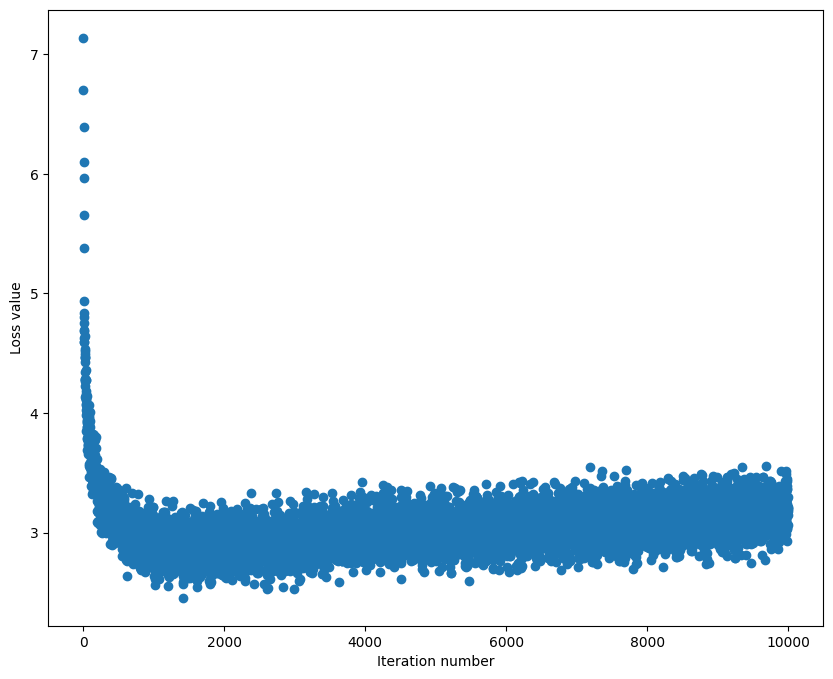

In [ ]:
plt.plot(loss_history, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

=== Sample 1 ===
source_sentence: ['il', 'se', 'pourrait', 'que', 'tu', 'veuilles', 'unk', 'un', 'il', 'a', 'ceci', '.', 'pad', 'pad', 'pad', 'pad']
target_sentence: ['bos', 'you', 'might', 'want', 'to', 'take', 'a', 'look', 'at', 'this', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
pred_sentence:   ['you', 're', 'not', 'to', 'be', 'a', 'unk', 'unk', '.', 'eos', '.', 'eos', '.', 'eos', '.', 'eos', '.']
=== Sample 2 ===
source_sentence: ['combien', 'd', 'heures', 'unk', 'unk', 'tu', 'dans', 'ton', 'bureau', '?', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
target_sentence: ['bos', 'how', 'many', 'hours', 'a', 'day', 'do', 'you', 'spend', 'in', 'your', 'office', '?', 'eos', 'pad', 'pad', 'pad', 'pad']
pred_sentence:   ['how', 'many', 'unk', 'you', 'have', 'a', 'unk', 'unk', '?', 'eos', '?', 'eos', '?', 'eos', 'you', 'do', '?']
=== Sample 3 ===
source_sentence: ['je', 'veux', 'm', 'assurer', 'que', 'tu', 'es', 'celui', 'que', 'tu', 'dis', 'etre', '.', 'pad', 'pad', 'pad']
target_sen

In [ ]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)

=== Sample 1 ===
source_sentence: ['il', 'est', 'temps', 'de', 'se', 'unk', 'sur', 'les', 'affaires', '.', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
target_sentence: ['bos', 'it', 's', 'time', 'to', 'get', 'down', 'to', 'business', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
pred_sentence:   ['it', 'is', 'unk', 'to', 'unk', 'the', 'unk', 'unk', '.', 'eos', '.', 'eos', '.', 'eos', '.', 'eos', '.']
=== Sample 2 ===
source_sentence: ['pour', 'conduire', 'une', 'voiture', 'on', 'a', 'besoin', 'd', 'un', 'permis', '.', 'pad', 'pad', 'pad', 'pad', 'pad']
target_sentence: ['bos', 'to', 'drive', 'a', 'car', 'you', 'need', 'a', 'license', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
pred_sentence:   ['unk', 'of', 'unk', 'unk', 'is', 'a', 'unk', 'unk', '.', 'eos', '.', 'eos', '.', 'eos', '.', 'eos', '.']
=== Sample 3 ===
source_sentence: ['j', 'unk', 'regarder', 'des', 'unk', 'qui', 'me', 'unk', 'a', 'reflechir', '.', 'pad', 'pad', 'pad', 'pad', 'pad']
target_sen

The following grading cells will assign partial credit based on the validation accuracy. Please do not remove.
- ${\geq} 20\%$: 15 points
- $15\% {\sim} 20\%$: 10 points
- $10\% {\sim} 15\%$: 5 points
- ${<} 10\%$: no credit

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

## LSTMs (15 points)

Vanilla RNNs are known to have vanishing gradient issues, which have been mitigated by LSTMs. Hence, replacing the RNNs in seq2seq models with LSTMs will probably improve performance. In this section, we will implement LSTMs from scratch.

Let us first implement the single-step LSTM update. We will be replicating the functionality of [`nn.LSTMCell`](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html?highlight=lstmcell#torch.nn.LSTMCell). Please refer to the documentation for more details. Note that for efficiency, the weights to be multiplied by the input are combined into a single weight matrix `weight_ih`, the weights to be multiplied by the previous hidden state are combined into `weight_hh`, and the biases are combined into a single vector `bias`. You are NOT allowed to use `nn.LSTMCell` or `nn.LSTM` in your implementation. For weight initialization, you can try [`nn.init.xavier_uniform_()`](https://pytorch.org/docs/stable/nn.init.html?highlight=xavier#torch.nn.init.xavier_uniform_) and [`nn.init.orthogonal_()`](https://pytorch.org/docs/stable/nn.init.html?highlight=orthogonal#torch.nn.init.orthogonal_). As suggested in this [post](https://danijar.com/tips-for-training-recurrent-neural-networks/), you may also initialize the forget gate bias to 1 so that the LSTM remembers more information by default.

In [ ]:
class LSTMCell(nn.Module):

  def __init__(self, input_size, hidden_size):
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    # Learnable parameters
    self.weight_ih = nn.Parameter(torch.Tensor(4 * self.hidden_size, self.input_size))
    self.weight_hh = nn.Parameter(torch.Tensor(4 * self.hidden_size, self.hidden_size))
    self.bias = nn.Parameter(torch.Tensor(4 * self.hidden_size))

    self.init_params()


  def init_params(self):
    #########################################################################
    # TODO:                                                                 #
    # Properly initialize the learnable parameters.                         #
    # This function should not have a "return" statement.                   #
    # You may use built-in functions in `torch.nn.init`.                    #
    #########################################################################
    # Replace "pass" statement with your code
    pass
    # END OF YOUR CODE


  def forward(self, input, state):
    # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]
    """
    Inputs:
    - input: A PyTorch tensor of shape (batch_size, input_size)
      containing a mini-batch of input features.
    - state: A tuple of hidden state and cell state from the previous step,
      both of which are PyTorch tensors of shape (batch_size, hidden_size).
      You may assume that `state` is not None.

    Returns:
    - hy: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the updated hidden state at the current step.
    - cy: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the updated cell state at the current step.

    For more details, check `torch.nn.LSTMCell`.
    """
    hx, cx = state
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    gates = input @ self.weight_ih.t() + hx @ self.weight_hh.t() + self.bias
    i_gate, f_gate, c_tilde, o_gate = gates.chunk(4, 1)
    i_gate = torch.sigmoid(i_gate)
    f_gate = torch.sigmoid(f_gate)
    c_tilde = torch.tanh(c_tilde)
    o_gate = torch.sigmoid(o_gate)
    cy = f_gate * cx + i_gate * c_tilde
    hy = o_gate * torch.tanh(cy)
    # END OF YOUR CODE
    return hy, cy

We will use the following helper functions to check your results:

In [ ]:
def max_diff(actual, expected):
  return (actual - expected).abs().max().item()

In [ ]:
def check_lstm_cell(batch_size, input_size, hidden_size):

  torch.manual_seed(0)
  torch_lstm_cell = nn.LSTMCell(input_size, hidden_size)
  lstm_cell = LSTMCell(input_size, hidden_size)

  lstm_cell.weight_ih.data = torch_lstm_cell.weight_ih.data
  lstm_cell.weight_hh.data = torch_lstm_cell.weight_hh.data
  lstm_cell.bias.data = torch_lstm_cell.bias_ih.data + torch_lstm_cell.bias_hh.data

  input = torch.empty(batch_size, input_size).normal_()
  state = torch.empty(batch_size, 2 * hidden_size).normal_().chunk(2, 1)

  (hy_expected, cy_expected) = torch_lstm_cell(input, state)
  (hy_actual, cy_actual) = lstm_cell(input, state)

  assert hy_actual.shape == hy_expected.shape, 'incorrect hy shape'
  assert cy_actual.shape == cy_expected.shape, 'incorrect cy shape'

  hy_diff = max_diff(hy_actual, hy_expected)
  cy_diff = max_diff(cy_actual, cy_expected)

  print('hy_diff = %e' % hy_diff)
  print('cy_diff = %e' % cy_diff)
  assert hy_diff < 1e-5, 'incorrect hy'
  assert cy_diff < 1e-5, 'incorrect cy'

In [ ]:
check_lstm_cell(batch_size=1, input_size=1, hidden_size=1)

hy_diff = 7.450581e-09
cy_diff = 1.490116e-08


In [ ]:
check_lstm_cell(batch_size=1, input_size=1, hidden_size=64)

hy_diff = 2.980232e-08
cy_diff = 2.980232e-08


In [ ]:
check_lstm_cell(batch_size=1, input_size=64, hidden_size=64)

hy_diff = 1.490116e-08
cy_diff = 1.192093e-07


In [ ]:
check_lstm_cell(batch_size=8, input_size=64, hidden_size=64)

hy_diff = 1.192093e-07
cy_diff = 1.788139e-07


Now that we have implemented the single-step update, we can apply it iteratively to a sequence of inputs and obtain the hidden states at each step. Please implement the `LSTM` class below, which contains `LSTMCell` as a submodule. You are NOT allowed to use `nn.LSTMCell` or `nn.LSTM` in your implementation.

You are encouraged (but not required) to develop an efficient implementation, in which the padding tokens are skipped and not fed to the `LSTMCell`. This can save computation by ~25% on our dataset, assuming the sentence length has a uniform distribution. Check this [tutorial](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning#decoder-1) for an illustration.

In [ ]:
class LSTM(nn.Module):

  def __init__(self, input_size, hidden_size):
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    self.lstm_cell = LSTMCell(self.input_size, self.hidden_size)


  def forward(self, input, input_len, init_state):
    # type: (Tensor, Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
    """
    Inputs:
    - input: A PyTorch tensor of shape (batch_size, max_seq_len, input_size)
      containing a mini-batch of sequences padded to `max_seq_len`.
    - input_len: A LongTensor of shape (batch_size,)
      containing the actual length of each sequence (before being padded).
    - init_state: A tuple of initial hidden state and cell state,
      both of which are PyTorch tensors of shape (batch_size, hidden_size).
      You may assume that `init_state` is not None.

    Returns:
    - hidden_states: A PyTorch tensor of shape (batch_size, max_seq_len, hidden_size)
      containing the hidden state `ht` at each step t.
    - hT: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the hidden state at the end of each sequence
      (i.e., `hT` encodes all tokens before the padding tokens).
    - cT: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the cell state at the end of each sequence
      (i.e., `cT` encodes all tokens before the padding tokens).
    """
    h, c = init_state
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    batch_size, max_seq_len, input_size = input.size()
    temp = (batch_size, max_seq_len, self.hidden_size)
    hidden_states = torch.zeros(temp)
    c_states = torch.zeros(temp)
    for i in range(max_seq_len):
      mask_i = i < input_len
      x_i = input[:, i, :]
      h, c = self.lstm_cell(x_i, (h, c))
      hidden_states[:, i, :] = h
      c_states[:, i, :] = c
      hidden_states[:, i, :] = hidden_states[:, i, :]*mask_i.unsqueeze(-1)
      c_states[:, i, :] = c_states[:, i, :] * mask_i.unsqueeze(-1)
    hT = hidden_states[torch.arange(batch_size), input_len-1, :]
    cT = c_states[torch.arange(batch_size), input_len-1, :]
    # END OF YOUR CODE
    return hidden_states, (hT, cT)

We will use the following helper function to check your results:

In [ ]:
def check_lstm(batch_size, max_seq_len, input_size, hidden_size):

  torch.manual_seed(0)
  torch_lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
  lstm = LSTM(input_size, hidden_size)

  lstm.lstm_cell.weight_ih.data = torch_lstm.weight_ih_l0.data
  lstm.lstm_cell.weight_hh.data = torch_lstm.weight_hh_l0.data
  lstm.lstm_cell.bias.data = torch_lstm.bias_ih_l0.data + torch_lstm.bias_hh_l0.data

  input = torch.empty(batch_size, max_seq_len, input_size).normal_()
  input_len = torch.randint(1, max_seq_len + 1, (batch_size,))
  init_state = torch.zeros(batch_size, 2 * hidden_size).chunk(2, 1)

  input_packed = pack_padded_sequence(
    input, input_len, batch_first=True, enforce_sorted=False)

  hidden_states_expected_packed, (hT_expected, cT_expected) = torch_lstm(input_packed)

  hidden_states_actual, (hT_actual, cT_actual) = lstm(input, input_len, init_state)

  assert hidden_states_actual.shape == (batch_size, max_seq_len, hidden_size), 'incorrect hidden_states shape'
  assert hT_actual.shape == (batch_size, hidden_size), 'incorrect hT shape'
  assert cT_actual.shape == (batch_size, hidden_size), 'incorrect cT shape'

  input_len = input_len.index_select(0, input_packed.sorted_indices)
  hidden_states_actual = hidden_states_actual.index_select(0, input_packed.sorted_indices)
  hidden_states_actual_packed = pack_padded_sequence(
    hidden_states_actual, input_len, batch_first=True, enforce_sorted=True)

  hidden_states_diff = max_diff(
    hidden_states_actual_packed.data,
    hidden_states_expected_packed.data)

  hT_diff = max_diff(hT_actual, hT_expected)
  cT_diff = max_diff(cT_actual, cT_expected)

  print('hidden_states_diff = %e' % hidden_states_diff)
  print('hT_diff = %e' % hT_diff)
  print('cT_diff = %e' % cT_diff)
  assert hidden_states_diff < 1e-5, 'incorrect hidden_states'
  assert hT_diff < 1e-5, 'incorrect hT'
  assert cT_diff < 1e-5, 'incorrect cT'

In [ ]:
check_lstm(batch_size=1, max_seq_len=1, input_size=1, hidden_size=1)

hidden_states_diff = 0.000000e+00
hT_diff = 0.000000e+00
cT_diff = 0.000000e+00


In [ ]:
check_lstm(batch_size=1, max_seq_len=16, input_size=1, hidden_size=1)

hidden_states_diff = 0.000000e+00
hT_diff = 0.000000e+00
cT_diff = 0.000000e+00


In [ ]:
check_lstm(batch_size=8, max_seq_len=16, input_size=1, hidden_size=1)

hidden_states_diff = 2.048910e-08
hT_diff = 3.725290e-09
cT_diff = 2.980232e-08


In [ ]:
check_lstm(batch_size=8, max_seq_len=16, input_size=64, hidden_size=64)

hidden_states_diff = 2.030283e-07
hT_diff = 2.030283e-07
cT_diff = 2.682209e-07


## Sequence to Sequence with LSTMs (25 points)

Now let us implement a seq2seq model with both the encoder and the decoder being LSTMs.

Implement `EncoderLSTM` and `DecoderLSTM` below. You may use PyTorch's built-in LSTMs or what you have implemented above.

In [ ]:
class EncoderLSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Set up the encoder components.                                        #
    #########################################################################
    # Replace "pass" statement with your code
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
    # END OF YOUR CODE


  def forward(self, source_text, source_len):
    # type: (Tensor, Tensor) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
    """
    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).

    Returns:
    - hidden_states: A PyTorch tensor of shape (batch_size, source_seq_len, hidden_size)
      containing the LSTM hidden state `ht` at each step t of the source sentences.
    - hT: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the LSTM hidden state at the end of each source sentence
      (i.e., `hT` encodes all tokens before the padding tokens).
    - cT: A PyTorch tensor of shape (batch_size, hidden_size)
      containing the LSTM cell state at the end of each source sentence
      (i.e., `cT` encodes all tokens before the padding tokens).
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    embedded = self.embedding(source_text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, source_len.cpu(), batch_first=True, enforce_sorted=False)
    packed_output, (hT, cT) = self.lstm(packed_embedded)
    hidden_states, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
    hT = hT.squeeze(0)
    cT = cT.squeeze(0)
    # END OF YOUR CODE
    return hidden_states, (hT, cT)

In [ ]:
class DecoderLSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Set up the decoder components.                                        #
    #########################################################################
    # Replace "pass" statement with your code
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
    self.f = nn.Linear(hidden_size, vocab_size)
    # END OF YOUR CODE


  def forward(self, target_text, target_len, source_last_state):
    # type: (Tensor, Tensor, Tuple[Tensor, Tensor]) -> Tensor
    """
    Perform next word prediction and compute loss.

    Inputs:
    - target_text: A LongTensor of shape (batch_size, target_seq_len)
      containing a mini-batch of target sentences padded to `target_seq_len`.
      Each token is represented by its index in the vocabulary.
    - target_len: A LongTensor of shape (batch_size,)
      containing the actual length of each target sentence (before being padded).
    - source_last_state: A tuple of hidden state and cell state at the end of
      each source sentence, both of shape (batch_size, hidden_size).

    Returns:
    - loss: A PyTorch scalar containing the loss for the mini-batch.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    embedded = self.embedding(target_text)
    h, c = source_last_state
    h = h.unsqueeze(0)
    c = c.unsqueeze(0)
    output, _ = self.lstm(embedded, (h, c))
    pred = self.f(output)
    target_len, sorted_indices = torch.sort(target_len, descending=True)
    target_text = target_text.index_select(0, sorted_indices)
    pred = pred.index_select(0, sorted_indices)
    target_len = target_len.cpu()
    target_text_packed = pack_padded_sequence(target_text[:, 1:], target_len-1, batch_first=True, enforce_sorted=True)
    pred_packed = pack_padded_sequence(pred, target_len-1, batch_first=True, enforce_sorted=True)
    loss = F.cross_entropy(pred_packed.data, target_text_packed.data, ignore_index=0)
    # END OF YOUR CODE
    return loss


  def predict(self, source_last_state, max_pred_len):
    # type: (Tuple[Tensor, Tensor], int) -> Tensor
    """
    Predict target sentences given the LSTM encoding of source sentences.
    The predicted word at step t will be used as input for step t+1.
    This is different from what is done in the forward pass.

    Inputs:
    - source_last_state: A tuple of hidden state and cell state at the end of
      each source sentence, both of shape (batch_size, hidden_size).
    - max_pred_len: (int) number of prediction steps.

    Returns:
    - pred: A LongTensor of shape (batch_size, max_pred_len)
      containing the predicted target sentences.
      Each token is represented by its index in the vocabulary.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the prediction phase.                                       #
    #########################################################################
    # Replace "pass" statement with your code
    h, c = source_last_state
    batch_size = h.shape[0]
    h = h.unsqueeze(0)
    c = c.unsqueeze(0)
    input_token = torch.ones((batch_size, 1), dtype=torch.long, device='cuda')
    temp_pred = []
    for i in range(max_pred_len):
      embedded = self.embedding(input_token)
      raw_output_i, (h, c) = self.lstm(embedded, (h, c))
      raw_output_i = raw_output_i.squeeze(1)
      logits = self.f(raw_output_i)
      pred_token = torch.argmax(logits, dim=1, keepdims=True)
      temp_pred.append(pred_token)
      input_token = pred_token
    pred = torch.cat(temp_pred, dim=1)
    # END OF YOUR CODE
    return pred

In [ ]:
class NMT_LSTM(nn.Module):

  def __init__(self, source_vocab_size, target_vocab_size, embedding_dim, hidden_size, max_pred_len):
    super().__init__()

    self.enc = EncoderLSTM(source_vocab_size, embedding_dim, hidden_size)
    self.dec = DecoderLSTM(target_vocab_size, embedding_dim, hidden_size)
    self.max_pred_len = max_pred_len


  def forward(self, source_text, source_len, target_text, target_len):
    # type: (Tensor, Tensor, Tensor, Tensor) -> Tensor
    """
    Perform next word prediction and compute loss.

    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).
    - target_text: A LongTensor of shape (batch_size, target_seq_len)
      containing a mini-batch of target sentences padded to `target_seq_len`.
      Each token is represented by its index in the vocabulary.
    - target_len: A LongTensor of shape (batch_size,)
      containing the actual length of each target sentence (before being padded).

    Returns:
    - loss: A PyTorch scalar containing the loss for the mini-batch.
    """
    _, source_last_state = self.enc(source_text, source_len)
    loss = self.dec(target_text, target_len, source_last_state)
    return loss


  def predict(self, source_text, source_len):
    # type: (Tensor, Tensor) -> Tensor
    """
    Predict the target sentence for each source sentence.
    The predicted word at step t will be used as input for step t+1.
    This is different from what is done in the forward pass.

    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).

    Returns:
    - pred: A LongTensor of shape (batch_size, max_pred_len)
      containing the predicted target sentences.
      Each token is represented by its index in the vocabulary.
    """
    _, source_last_state = self.enc(source_text, source_len)
    pred = self.dec.predict(source_last_state, self.max_pred_len)
    return pred

### Training

A basic training script is provided below. You can make modifications as appropriate.

To get full credit, your model should **achieve at least 35% validation accuracy**.

In [ ]:
torch.manual_seed(0)

batch_size = 40
num_epochs = 50
learning_rate = 0.0001  # TODO
weight_decay = 0.00001  # TODO

embedding_dim = 256*8
hidden_size = 256*8

source_vocab, target_vocab, train_loader, val_loader = get_data_loader(
  source_text, target_text, batch_size)
model = NMT_LSTM(source_vocab.size, target_vocab.size, embedding_dim, hidden_size, MAX_LEN + 1)
model = model.cuda()

model, loss_history = train(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay)

Train Epoch:   0 	 Loss: 7.128574 	 Val Acc: 0.043408
Train Epoch:   1 	 Loss: 3.366969 	 Val Acc: 21.040066
Train Epoch:   2 	 Loss: 2.451016 	 Val Acc: 25.814993
Train Epoch:   3 	 Loss: 2.048325 	 Val Acc: 28.862265
Train Epoch:   4 	 Loss: 1.567008 	 Val Acc: 31.115163
Train Epoch:   5 	 Loss: 1.229347 	 Val Acc: 33.025133
Train Epoch:   6 	 Loss: 1.111479 	 Val Acc: 35.542822
Train Epoch:   7 	 Loss: 0.648643 	 Val Acc: 36.927551
Train Epoch:   8 	 Loss: 0.576995 	 Val Acc: 39.705691
Train Epoch:   9 	 Loss: 0.430971 	 Val Acc: 40.439293
Train Epoch:  10 	 Loss: 0.303038 	 Val Acc: 42.258107
Train Epoch:  11 	 Loss: 0.201153 	 Val Acc: 43.230455
Train Epoch:  12 	 Loss: 0.155518 	 Val Acc: 43.069844
Train Epoch:  13 	 Loss: 0.133039 	 Val Acc: 44.463255
Train Epoch:  14 	 Loss: 0.080813 	 Val Acc: 44.645570
Train Epoch:  15 	 Loss: 0.054161 	 Val Acc: 44.988497
Train Epoch:  16 	 Loss: 0.052750 	 Val Acc: 45.500716
Train Epoch:  17 	 Loss: 0.035762 	 Val Acc: 45.144767
Train Epoch

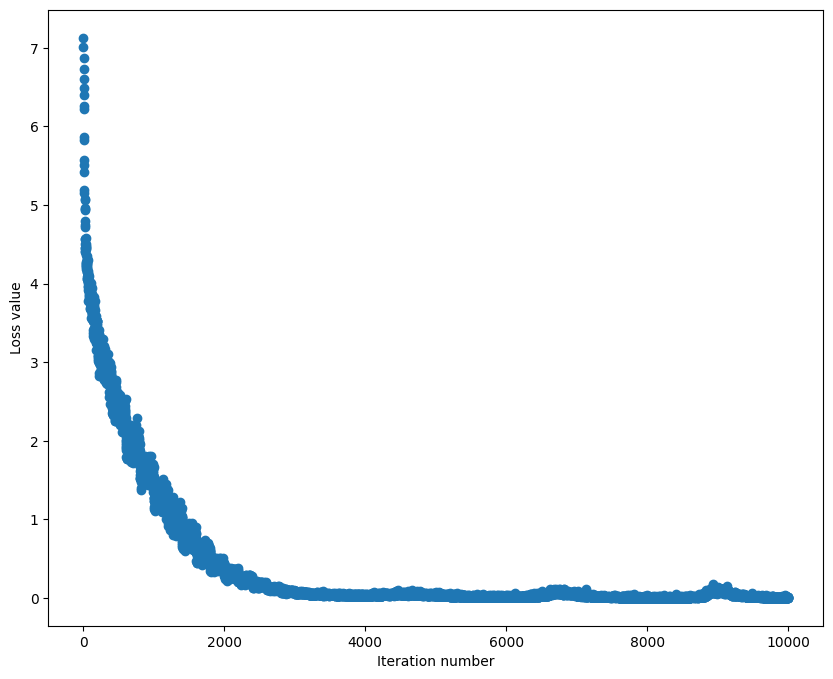

In [ ]:
plt.plot(loss_history, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

=== Sample 1 ===
source_sentence: ['vous', 'etiez', 'ici', 'pas', 'plus', 'tard', 'que', 'l', 'autre', 'jour', 'n', 'est', 'ce', 'pas', '?', 'pad']
target_sentence: ['bos', 'you', 'were', 'here', 'just', 'the', 'other', 'day', 'weren', 't', 'you', '?', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']
pred_sentence:   ['you', 'were', 'here', 'just', 'the', 'other', 'day', 'weren', 't', 'you', '?', 'eos', 'eos', '?', 'eos', 'eos', 'eos']
=== Sample 2 ===
source_sentence: ['il', 'semble', 'n', 'avoir', 'aucun', 'sens', 'de', 'l', 'unk', '.', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
target_sentence: ['bos', 'he', 'seems', 'to', 'have', 'no', 'sense', 'of', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
pred_sentence:   ['he', 'seems', 'to', 'have', 'no', 'sense', 'of', 'unk', '.', 'eos', 'eos', 'eos', '.', 'eos', 'eos', 'eos', 'eos']
=== Sample 3 ===
source_sentence: ['du', 'bon', 'bois', 'de', 'unk', 'est', 'difficile', 'a', 'trouver', 'de', 'nos', 'jours', '.', 'pad', 'pad

In [ ]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)

=== Sample 1 ===
source_sentence: ['j', 'ai', 'eu', 'du', 'mal', 'a', 'la', 'convaincre', 'des', 'unk', 'de', 'la', 'unk', '.', 'pad', 'pad']
target_sentence: ['bos', 'i', 'had', 'unk', 'unk', 'her', 'of', 'the', 'unk', 'of', 'smoking', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']
pred_sentence:   ['i', 'had', 'a', 'unk', 'cold', 'of', 'the', 'unk', 's', 'unk', '.', 'eos', 'eos', 'eos', '.', 'eos', 'eos']
=== Sample 2 ===
source_sentence: ['pourquoi', 'ne', 'me', 'unk', 'tu', 'pas', 'ce', 'que', 'tu', 'veux', 'vraiment', 'savoir', '?', 'pad', 'pad', 'pad']
target_sentence: ['bos', 'why', 'don', 't', 'you', 'ask', 'me', 'what', 'you', 'really', 'want', 'to', 'know', '?', 'eos', 'pad', 'pad', 'pad']
pred_sentence:   ['why', 'don', 't', 'you', 'ask', 'me', 'what', 'you', 'really', 'want', 'to', 'know', '?', 'eos', 'eos', '?', 'eos']
=== Sample 3 ===
source_sentence: ['j', 'ai', 'unk', 'le', 'livre', 'que', 'j', 'avais', 'perdu', 'hier', '.', 'pad', 'pad', 'pad', 'pad', 'pad']
target_sen

The following grading cells will assign partial credit based on the validation accuracy. Please do not remove.
- ${\geq} 35\%$: 25 points
- $32\% {\sim} 35\%$: 20 points
- $28\% {\sim} 32\%$: 15 points
- $24\% {\sim} 28\%$: 10 points
- $20\% {\sim} 24\%$: 5 points
- ${<} 20\%$: no credit

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

## Sequence to Sequence with Attention (35 points)

So far we have been compressing the entire source sentence into some fixed-length encoding vector, from which the decoder needs to extract relevant information to predict each target word. However, as suggested in this [paper](https://arxiv.org/pdf/1409.0473.pdf), such a fixed-length encoding can become a bottleneck when the sentence gets longer. A better approach would be to let the decoder have direct access to the encoder hidden states at all steps. This allows the decoder to focus on relevant words in the source sentence more easily when predicting a target word.

<img src="https://guillaumegenthial.github.io/assets/img2latex/seq2seq_attention_mechanism_new.svg" width=800>

As depicted above, at each step $t$, the decoder uses its previous hidden state $h_{t-1}^\text{dec}$ to compute an attention score $\alpha_{t, i}$ for each word $i$ in the source sentence:
$$
\alpha_{t, i} = f(h_{t-1}^\text{dec}, h_i^\text{enc}).
$$
Then, a context vector $c_t$ is computed by a weighted sum of the encoder hidden states:
$$
\bar{\alpha}_{t, :} = \text{softmax}(\alpha_{t, :}),
$$
$$
c_t = \sum_i \bar{\alpha}_{t, i} h_i^\text{enc}.
$$
This context vector is expected to capture the most relevant information for prediction at step $t$. Hence, it is concatenated with the original decoder input $x_t$ and fed to the decoder LSTM:
$$
h_t^\text{dec} = \text{LSTM}^\text{dec}(h_{t-1}^\text{dec}, \text{concat}[x_t, c_t]).
$$
The predicted distribution $p_t$ for the next word is computed by a fully connected layer $g(\cdot)$:
$$
p_t = g(\text{concat}[h_t^\text{dec}, x_t, c_t]).
$$

Let us first implement the attention mechanism. This includes the scoring function $f(\cdot, \cdot)$ and the $\text{softmax}(\cdot)$. Since the padding tokens do not contain any useful information, they should be masked out in the softmax. Implement the `masked_softmax()` function below that computes softmax after masking out the padding tokens:

In [ ]:
def masked_softmax(attention_scores, valid_len):
  """
  Inputs:
  - attention_scores: A PyTorch tensor of shape (batch_size, max_seq_len)
    containing the unnormalized per-token attention scores for a mini-batch of sequences,
    each padded to `max_seq_len`. The scores are to be normalized
    across the non-padding tokens within each sequence.
  - valid_len: A LongTensor of shape (batch_size,)
    containing the number of non-padding tokens for each sequence.

  Returns:
  - attention_weights: A PyTorch tensor of shape (batch_size, max_seq_len)
    containing the normalized per-token attention weights. For each sequence,
    the sum of attention weights over non-padding tokens should be (approximately) 1,
    while the attention weights for padding tokens should be (approximately) 0.
  """
  mask_value = -1e9
  #########################################################################
  # TODO:                                                                 #
  # Replace attention scores at padding tokens with `mask_value`,         #
  # then compute softmax.                                                 #
  #########################################################################
  # Replace "pass" statement with your code
  batch_size, max_seq_len = attention_scores.shape
  mask = torch.arange(max_seq_len, device=attention_scores.device).expand(batch_size, max_seq_len)>=valid_len.unsqueeze(1)
  attention_scores.masked_fill_(mask, mask_value)
  attention_weights = torch.softmax(attention_scores, dim=1)
  # END OF YOUR CODE
  return attention_weights

We will use the following helper function to check your results:

In [ ]:
def check_masked_softmax(batch_size, max_seq_len):

  torch.manual_seed(0)
  attention_scores = torch.empty(batch_size, max_seq_len).normal_()
  valid_len = torch.randint(1, max_seq_len + 1, (batch_size,))

  attention_weights = masked_softmax(attention_scores, valid_len)

  attention_weights_cumsum = attention_weights.cumsum(dim=-1)

  attention_weights_cumsum_all = attention_weights_cumsum[:, -1]
  attention_weights_cumsum_valid = attention_weights_cumsum[torch.arange(batch_size), valid_len - 1]

  assert (attention_weights >= 0).all()
  assert max_diff(attention_weights_cumsum_all, 1) < 1e-5
  assert max_diff(attention_weights_cumsum_valid, 1) < 1e-5
  print('Test passed')

In [ ]:
check_masked_softmax(batch_size=1, max_seq_len=1)

Test passed


In [ ]:
check_masked_softmax(batch_size=64, max_seq_len=32)

Test passed


Next, we will implement the scoring function as an MLP with one hidden layer. Consider the general setting where we are given a set of key-value pairs $\{(k_i, v_i)\}$ and a query $q$. The attention scores can be computed as:
$$
\alpha(q, k_i) = w^\top \text{tanh}(W_q q + W_k k_i + b),
$$
where $w$, $W_q$, $W_k$, and $b$ are learnable parameters, and the dimension of $w$ is the hidden size of the MLP.

The attention output is a weighted sum of values:
$$
c = \sum_i \bar{\alpha}(q, k_i) v_i,
$$
where $\bar{\alpha}(q, k_i)$ is the normalized attention weights.

In [ ]:
class MLP_Attention(nn.Module):

  def __init__(self, query_dim, key_dim, hidden_size):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Set up the module components.                                         #
    #########################################################################
    # Replace "pass" statement with your code
    self.layer1 = nn.Linear(query_dim+key_dim, hidden_size)
    self.layer2 = nn.Linear(hidden_size, 1)
    # END OF YOUR CODE


  def forward(self, query, keys, values, valid_len):
    # type: (Tensor, Tensor, Tensor, Tensor) -> Tensor
    """
    Inputs:
    - query: A PyTorch tensor of shape (batch_size, query_dim).
    - keys: A PyTorch tensor of shape (batch_size, max_seq_len, key_dim)
      containing the per-token keys for a mini-batch of sequences,
      each padded to `max_seq_len`.
    - values: A PyTorch tensor of shape (batch_size, max_seq_len, value_dim)
      containing the per-token values for a mini-batch of sequences,
      each padded to `max_seq_len`.
    - valid_len: A LongTensor of shape (batch_size,)
      containing the number of non-padding tokens for each sequence.

    Returns:
    - attention: A PyTorch tensor of shape (batch_size, value_dim)
      containing the weighted sum of values, where the weights are
      computed by MLP attention over the non-padding tokens.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass without explicit loops.                    #
    #########################################################################
    # Replace "pass" statement with your code
    _, max_seq_len, _ = keys.shape
    expanded_query = query.unsqueeze(1).repeat(1, max_seq_len, 1)
    concat_input = torch.cat((expanded_query, keys), dim=2)
    h = torch.tanh(self.layer1(concat_input))
    scores = self.layer2(h).squeeze(2)
    soft_scores = masked_softmax(scores, valid_len)
    attention = torch.bmm(soft_scores.unsqueeze(1), values).squeeze(1)
    # END OF YOUR CODE
    return attention

Now we can implement the seq2seq model with attention. Note that only the decoder needs to be changed. Implement `DecoderAttLSTM` below:

In [ ]:
class DecoderAttLSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Set up the decoder components.                                        #
    #########################################################################
    # Replace "pass" statement with your code
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.attention = MLP_Attention(hidden_size, hidden_size, hidden_size)
    self.lstm = nn.LSTM(hidden_size+embedding_dim, hidden_size, batch_first=True)
    self.f = nn.Linear(hidden_size, vocab_size)
    # END OF YOUR CODE


  def forward(self, target_text, target_len, source_last_state, source_hidden_states, source_len):
    # type: (Tensor, Tensor, Tuple[Tensor, Tensor], Tensor, Tensor) -> Tensor
    """
    Perform next word prediction and compute loss.

    Inputs:
    - target_text: A LongTensor of shape (batch_size, target_seq_len)
      containing a mini-batch of target sentences padded to `target_seq_len`.
      Each token is represented by its index in the vocabulary.
    - target_len: A LongTensor of shape (batch_size,)
      containing the actual length of each target sentence (before being padded).
    - source_last_state: A tuple of hidden state and cell state at the end of
      each source sentence, both of shape (batch_size, hidden_size).
    - source_hidden_states: A PyTorch tensor of shape (batch_size, source_seq_len, hidden_size)
      containing the LSTM hidden state `ht` at each step t of the source sentences.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).

    Returns:
    - loss: A PyTorch scalar containing the loss for the mini-batch.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    embedded = self.embedding(target_text)
    h, c = source_last_state
    h = h.unsqueeze(0)
    c = c.unsqueeze(0)
    temp_context = self.attention(h.squeeze(0), source_hidden_states, source_hidden_states, source_len)
    _, target_seq_len = target_text.shape
    temp_context = temp_context.unsqueeze(1).expand(-1, target_seq_len, -1)
    lstm_in = torch.cat([embedded, temp_context], dim=2)
    output, _ = self.lstm(lstm_in, (h, c))
    pred = self.f(output)
    target_len, sorted_indices = torch.sort(target_len, descending=True)
    target_text = target_text.index_select(0, sorted_indices)
    pred = pred.index_select(0, sorted_indices)
    target_len = target_len.cpu()
    target_text_packed = pack_padded_sequence(target_text[:, 1:], target_len-1, batch_first=True, enforce_sorted=True)
    pred_packed = pack_padded_sequence(pred, target_len-1, batch_first=True, enforce_sorted=True)
    loss = F.cross_entropy(pred_packed.data, target_text_packed.data, ignore_index=0)
    # END OF YOUR CODE
    return loss


  def predict(self, source_last_state, max_pred_len, source_hidden_states, source_len):
    # type: (Tuple[Tensor, Tensor], int, Tensor, Tensor) -> Tensor
    """
    Predict target sentences given the LSTM encoding of source sentences.
    The predicted word at step t will be used as input for step t+1.
    This is different from what is done in the forward pass.

    Inputs:
    - source_last_state: A tuple of hidden state and cell state at the end of
      each source sentence, both of shape (batch_size, hidden_size).
    - max_pred_len: (int) number of prediction steps.
    - source_hidden_states: A PyTorch tensor of shape (batch_size, source_seq_len, hidden_size)
      containing the LSTM hidden state `ht` at each step t of the source sentences.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).

    Returns:
    - pred: A LongTensor of shape (batch_size, max_pred_len)
      containing the predicted target sentences.
      Each token is represented by its index in the vocabulary.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the prediction phase.                                       #
    #########################################################################
    # Replace "pass" statement with your code
    h, c = source_last_state
    h = h.unsqueeze(0)
    c = c.unsqueeze(0)
    batch_size = source_len.shape[0]
    input_token = torch.ones((batch_size, 1), dtype=torch.long, device="cuda")
    temp_pred = []
    for i in range(max_pred_len):
      embedded = self.embedding(input_token)
      temp_context = self.attention(h.squeeze(0), source_hidden_states, source_hidden_states, source_len)
      temp_context = temp_context.unsqueeze(1)
      lstm_in = torch.cat([embedded, temp_context], dim=2)
      temp_raw_output, (h, c) = self.lstm(lstm_in, (h, c))
      temp_raw_output = temp_raw_output.squeeze(1)
      logits = self.f(temp_raw_output)
      pred_token = torch.argmax(logits, dim=1, keepdims=True)
      temp_pred.append(pred_token)
      input_token = pred_token
    pred = torch.cat(temp_pred, dim=1)
    # END OF YOUR CODE
    return pred

In [ ]:
class NMT_AttLSTM(nn.Module):

  def __init__(self, source_vocab_size, target_vocab_size, embedding_dim, hidden_size, max_pred_len):
    super().__init__()

    self.enc = EncoderLSTM(source_vocab_size, embedding_dim, hidden_size)
    self.dec = DecoderAttLSTM(target_vocab_size, embedding_dim, hidden_size)
    self.max_pred_len = max_pred_len


  def forward(self, source_text, source_len, target_text, target_len):
    # type: (Tensor, Tensor, Tensor, Tensor) -> Tensor
    """
    Perform next word prediction and compute loss.

    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).
    - target_text: A LongTensor of shape (batch_size, target_seq_len)
      containing a mini-batch of target sentences padded to `target_seq_len`.
      Each token is represented by its index in the vocabulary.
    - target_len: A LongTensor of shape (batch_size,)
      containing the actual length of each target sentence (before being padded).

    Returns:
    - loss: A PyTorch scalar containing the loss for the mini-batch.
    """
    source_hidden_states, source_last_state = self.enc(source_text, source_len)
    loss = self.dec(target_text, target_len, source_last_state, source_hidden_states, source_len)
    return loss


  def predict(self, source_text, source_len):
    # type: (Tensor, Tensor) -> Tensor
    """
    Predict the target sentence for each source sentence.
    The predicted word at step t will be used as input for step t+1.
    This is different from what is done in the forward pass.

    Inputs:
    - source_text: A LongTensor of shape (batch_size, source_seq_len)
      containing a mini-batch of source sentences padded to `source_seq_len`.
      Each token is represented by its index in the vocabulary.
    - source_len: A LongTensor of shape (batch_size,)
      containing the actual length of each source sentence (before being padded).

    Returns:
    - pred: A LongTensor of shape (batch_size, max_pred_len)
      containing the predicted target sentences.
      Each token is represented by its index in the vocabulary.
    """
    source_hidden_states, source_last_state = self.enc(source_text, source_len)
    pred = self.dec.predict(source_last_state, self.max_pred_len, source_hidden_states, source_len)
    return pred

### Training

A basic training script is provided below. You can make modifications as appropriate.

To get full credit, your model should **achieve at least 44% validation accuracy**.

In [ ]:
torch.manual_seed(0)

batch_size = 40
num_epochs = 50
learning_rate = 0.0003  # TODO
weight_decay = 0.00003  # TODO

embedding_dim = 2048
hidden_size = 2048

source_vocab, target_vocab, train_loader, val_loader = get_data_loader(
  source_text, target_text, batch_size)
model = NMT_AttLSTM(source_vocab.size, target_vocab.size, embedding_dim, hidden_size, MAX_LEN + 1)
model = model.cuda()

model, loss_history = train(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay)

In [ ]:
plt.plot(loss_history, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

In [ ]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)

The following grading cells will assign partial credit based on the validation accuracy. Please do not remove.
- ${\geq} 44\%$: 30 points
- $41\% {\sim} 44\%$: 25 points
- $37\% {\sim} 41\%$: 20 points
- $33\% {\sim} 37\%$: 15 points
- $29\% {\sim} 33\%$: 10 points
- $25\% {\sim} 29\%$: 5 points
- ${<} 25\%$: no credit

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.

In [ ]:
# Grading cell. Do not remove.